In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-01-24 21:03:22.038739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-24 21:03:22.038777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['diurnal_temperature_range'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["diurnal_temperature_range"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_dtr = y_train_tas[~nan_train_mask] # change made here dtr to tas
assert len(X_train) == len(y_train_dtr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
dtr_truth = tas_truth[~nan_test_mask] # change made here dtr to tas

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_dtr_mean, train_dtr_std = y_train_dtr.mean(), y_train_dtr.std()
y_train_dtr = (y_train_dtr - train_dtr_mean) / train_dtr_std

### Prepare model

In [7]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2024-01-24 21:04:51.456435: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-24 21:04:51.456672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-24 21:04:51.456752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-24 21:04:51.458682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-01-24 21:04:51.458764: W tensorflow/stream_executor/platform/default/dso_loader

In [8]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_dtr.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [9]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26854D+07    |proj g|=  1.84502D+06


 This problem is unconstrained.



At iterate    1    f=  1.11613D+07    |proj g|=  8.94905D+05

At iterate    2    f=  1.09653D+07    |proj g|=  1.25952D+05

At iterate    3    f=  1.09480D+07    |proj g|=  1.22959D+05

At iterate    4    f=  1.08528D+07    |proj g|=  4.55159D+05

At iterate    5    f=  1.06939D+07    |proj g|=  7.28017D+05

At iterate    6    f=  1.05146D+07    |proj g|=  4.80741D+05

At iterate    7    f=  1.04623D+07    |proj g|=  1.05185D+05

At iterate    8    f=  1.04601D+07    |proj g|=  1.46344D+04

At iterate    9    f=  1.04599D+07    |proj g|=  1.13620D+04

At iterate   10    f=  1.04596D+07    |proj g|=  3.15654D+04

At iterate   11    f=  1.04590D+07    |proj g|=  5.30216D+04

At iterate   12    f=  1.04575D+07    |proj g|=  8.47461D+04

At iterate   13    f=  1.04547D+07    |proj g|=  1.11495D+05

At iterate   14    f=  1.04501D+07    |proj g|=  1.15381D+05

At iterate   15    f=  1.04479D+07    |proj g|=  3.37232D+04

At iterate   16    f=  1.04439D+07    |proj g|=  5.47281D+03

At iter

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 10345694.478609476
        x: [ 5.239e+00  2.461e+00 ... -9.511e-01 -2.069e-01]
      nit: 467
      jac: [ 1.756e+01  7.933e+00 ... -2.829e+01 -4.547e+00]
     nfev: 549
     njev: 549
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

### Predict on testing set

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_dtr_std + train_dtr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_dtr_std

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_dtr = np.reshape(posterior_mean, [86, 96, 144])
posterior_dtr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_dtr_data = xr.DataArray(posterior_dtr, dims=dtr_truth.dims, coords=dtr_truth.coords)
posterior_dtr_std_data = xr.DataArray(posterior_dtr_std, dims=dtr_truth.dims, coords=dtr_truth.coords)

In [14]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(dtr_truth[35], posterior_dtr_data[35])}")
print(f"RMSE at 2100: {get_rmse(dtr_truth[85], posterior_dtr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(dtr_truth[30:41], posterior_dtr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(dtr_truth[75:], posterior_dtr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(dtr_truth[35:], posterior_dtr_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(dtr_truth[-20:].mean(dim='time'), posterior_dtr_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.1322085840424403
RMSE at 2100: 0.14554522566412526
RMSE 2045-2055: 0.13904279425613106
RMSE 2090-2100: 0.16215637201330552
RMSE 2050-2100: 0.15406835035575564
RMSE average last 20y: 0.10358503135084846


[Text(0.5, 1.0, 'Difference')]

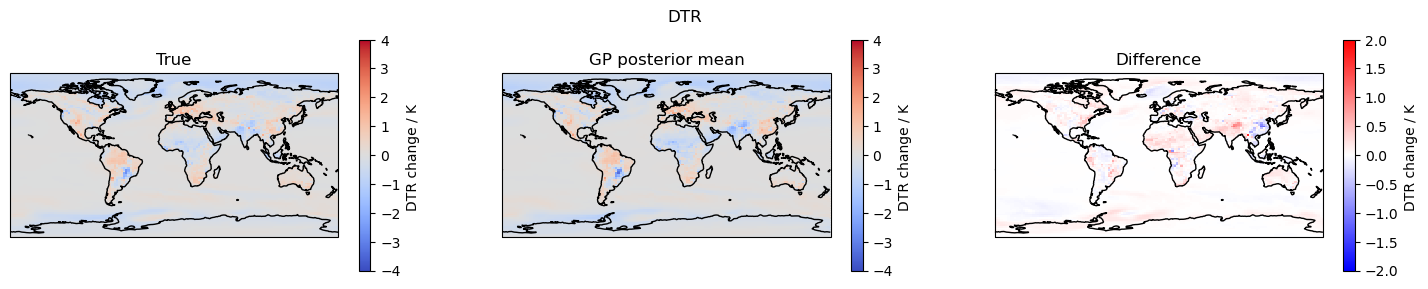

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_dtr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = dtr_truth - posterior_dtr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Really just CO2 (1.54) 

In [16]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.20117]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.52987
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,5.21477
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.07051
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.51625
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.13993
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.02444, 3.11542, 1.44365..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.33647
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.08501, 4.44612, 9.02954..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.32666


In [17]:
# Save predictions
posterior_dtr_data.to_netcdf('climatebench-gp-posterior-mean-dtr-test-2019-2100.nc')
posterior_dtr_std_data.to_netcdf('climatebench-gp-posterior-std-dtr-test-2019-2100.nc')